In [1]:
import pandas as pd
import numpy as np
from Bio.Seq import Seq
import matplotlib.pyplot as plt
plt.rcParams['savefig.dpi'] = 300
plt.rcParams["figure.figsize"] = (10,5)
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize

In [2]:
df = pd.read_csv('../data/221026_recheck-miseq-triplicates/barseq_counts.csv')

# normalize read count
sample_list = ['1','2','3','4','5','6']
for sample in sample_list:
    df[f'{sample}_norm'] = df[sample]/df[sample].sum()

# fold change
for t0,t1 in zip([1,2,3],[4,5,6]):
    df[f'fold_change_{t0}'] = df[f'{t1}_norm'] / df[f'{t0}_norm']
    
df['pkr'] = df['var'].str.split('_').str[0]
df['k3l'] = df['var'].str.split('_').str[1]

# down-select for K3L-NULL and K3L-WT
def k3l_type(row, k3l_stop=40):
    x = row['k3l'].split('-')[1]
    if x == 'WT':
        return 'K3L-WT'
    elif x[-1] == '*' and int(x[1:-1]) < k3l_stop:
        return 'K3L-STOP' 
    else:
        return 'K3L-VAR'
    
df['k3l_type'] = df.apply(lambda x: k3l_type(x), axis=1)

# select for only pairs to K3L-WT
df1 = df.query('k3l == "K3L-WT"')

pkr_resistant_vars = ['E375V','I378T', 'R382I', 'I405M', 'S448G', 'M455V', 'A473T', 'E480D', 'D486V', 'T491S', 'S504L', 'E524V']
def pkr_type(x, pkr_stop = 350):
    if x[-1] == "*" and int(x.split('-')[1][1:-1]) < pkr_stop:
        return "STOP"
    elif x[-2:] == 'WT':
        return "WT"
    elif x.split('-')[1] in pkr_resistant_vars:
        return "Resistant"
    else:
        return 'Variant'
df1['pkr_type'] = df1['pkr'].apply(pkr_type)

df1['mean_fold_change'] = df1[['fold_change_1','fold_change_2','fold_change_3']].mean(axis=1)

df1['log2_fc'] = np.log2(df1['mean_fold_change'])

/var/folders/fq/q1cflf795cgbnmbhdyn8d9nntyw5jt/T/ipykernel_52132/1457583168.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['pkr_type'] = df1['pkr'].apply(pkr_type)
/var/folders/fq/q1cflf795cgbnmbhdyn8d9nntyw5jt/T/ipykernel_52132/1457583168.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['mean_fold_change'] = df1[['fold_change_1','fold_change_2','fold_change_3']].mean(axis=1)
/var/folders/fq/q1cflf795cgbnmbhdyn8d9nntyw5jt/T/ipykernel_52132/1457583168.py:44: SettingWithCopyWarning: 
A value

In [3]:
# take only measures with >10 reads at TP-0
df1['tp0_read_mean'] = df1[['1','2','3']].mean(axis=1)
df2 = df1.query('tp0_read_mean >= 10')

df3 = df2.query('k3l_type == "K3L-WT"')[['pkr','log2_fc']]

/var/folders/fq/q1cflf795cgbnmbhdyn8d9nntyw5jt/T/ipykernel_52132/2511380415.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['tp0_read_mean'] = df1[['1','2','3']].mean(axis=1)


In [6]:
df3.sort_values('log2_fc').head(20)

,pkr,log2_fc
404,PKR-I270M,-0.833162
192,PKR-E375A,-0.803216
120,PKR-I506M,-0.612526
390,PKR-E490Q,-0.602758
506,PKR-L482F,-0.543738
283,PKR-H483D,-0.536211
325,PKR-F494S,-0.512827
109,PKR-K371N,-0.506696
507,PKR-I270T,-0.494339
616,PKR-T258A,-0.491365


In [7]:
# + H-K, - D-E, Polar-neutral C-T, Non-polar A-V, Aromatic F-Y, Unique G-P, Stop *
aa_list = ['H','K','R','D','E','C','M','N','Q','S','T','A','I','L','V','F','W','Y','G','P','*']

# create a 3-level dictionary
df3['wt_aa'] = df3.pkr.str.split('-').str[1].str[:1]
df3['var_aa'] = df3.pkr.str.split('-').str[1].str[-1:]
df3['pos'] = df3.pkr.str.split('-').str[1].str[1:-1]
df3['pos'] = pd.to_numeric(df3['pos'])

In [8]:
df3.sort_values('log2_fc').head(20)

,pkr,log2_fc,wt_aa,var_aa,pos
404,PKR-I270M,-0.833162,I,M,270.0
192,PKR-E375A,-0.803216,E,A,375.0
120,PKR-I506M,-0.612526,I,M,506.0
390,PKR-E490Q,-0.602758,E,Q,490.0
506,PKR-L482F,-0.543738,L,F,482.0
283,PKR-H483D,-0.536211,H,D,483.0
325,PKR-F494S,-0.512827,F,S,494.0
109,PKR-K371N,-0.506696,K,N,371.0
507,PKR-I270T,-0.494339,I,T,270.0
616,PKR-T258A,-0.491365,T,A,258.0


/var/folders/fq/q1cflf795cgbnmbhdyn8d9nntyw5jt/T/ipykernel_84982/948003552.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['tp0_read_mean'] = df1[['1','2','3']].mean(axis=1)
/var/folders/fq/q1cflf795cgbnmbhdyn8d9nntyw5jt/T/ipykernel_84982/948003552.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df3.append(missing_df)


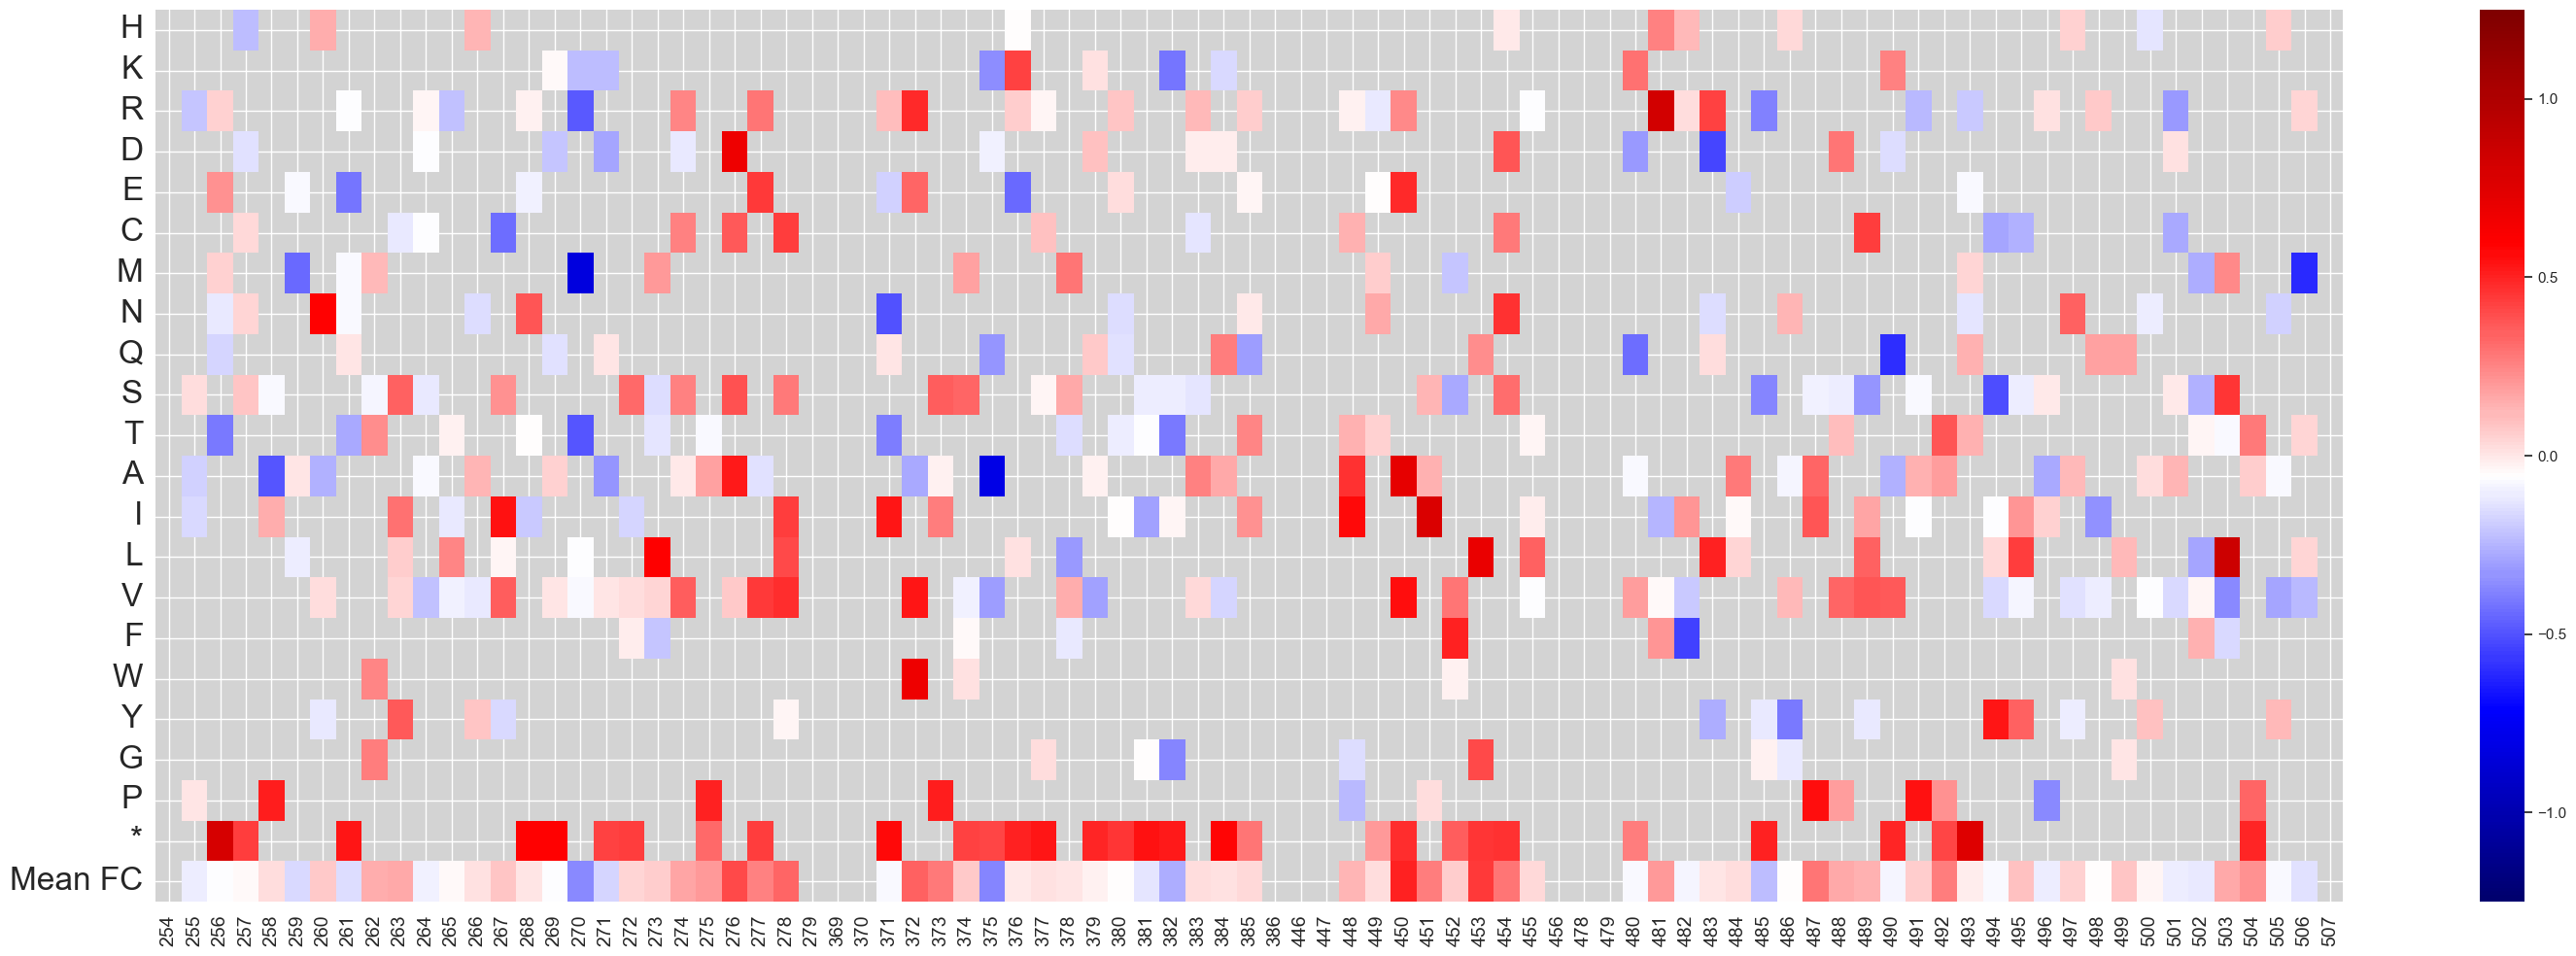

In [4]:
# remove the PKR-WT variants and residue variant at 420
df3.query('pkr != "PKR-WT"', inplace=True)
df3.query('pkr != "PKR-I420T"', inplace=True)
df3.reset_index(drop=True, inplace=True)

# pivot the df
df3 = df3.pivot(index='pos',columns='var_aa', values='log2_fc')

no_stops_aa = aa_list.copy()
no_stops_aa.remove("*")

# average fold change for res position
df3['Mean FC'] = df3[no_stops_aa].mean(axis=1)

# add missing positions to heatmap
good_pos = df3.index.tolist()
#full_pos = list(range(250,551))
full_pos = list(range(254,280))+list(range(369,387))+list(range(446,457))+list(range(478,508))
missing = list(set(full_pos) - set(good_pos))
missing_df = pd.DataFrame(index=missing)
df3 = df3.append(missing_df)
df3.sort_index(inplace=True)
df3.index = df3.index.astype(int)
sns.set_context("talk")

sns.set(rc={'axes.facecolor':'white'})
fig, ax = plt.subplots(figsize=(30,10))
g = sns.heatmap(df3[aa_list+['Mean FC']].T, cmap='seismic', center=-0.061617, vmin=-1.25, vmax=1.25) # center=0.966365 when no lognorm()

#plt.yticks(rotation=0)
#fig = ax.get_figure()
plt.yticks(rotation=0)

plt.tick_params(axis='y', which='major', labelsize=24)
plt.tick_params(axis='x', which='major', labelsize=14)

#ax.set_xticklabels('')

g.set_facecolor('#D3D3D3'), # gray the background

fig = ax.get_figure()
plt.title('') # Deep mutation scan of PKR variants against K3L-WT log2 FC
plt.ylabel('')
plt.xlabel('')
plt.tight_layout()
#fig.savefig('../img/heatmap-pkr_log2-fc.pdf')

In [17]:
df2.pkr.nunique()


406

/tmp/ipykernel_16883/3781712227.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['tp0_read_mean'] = df1[['1','2','3']].mean(axis=1)


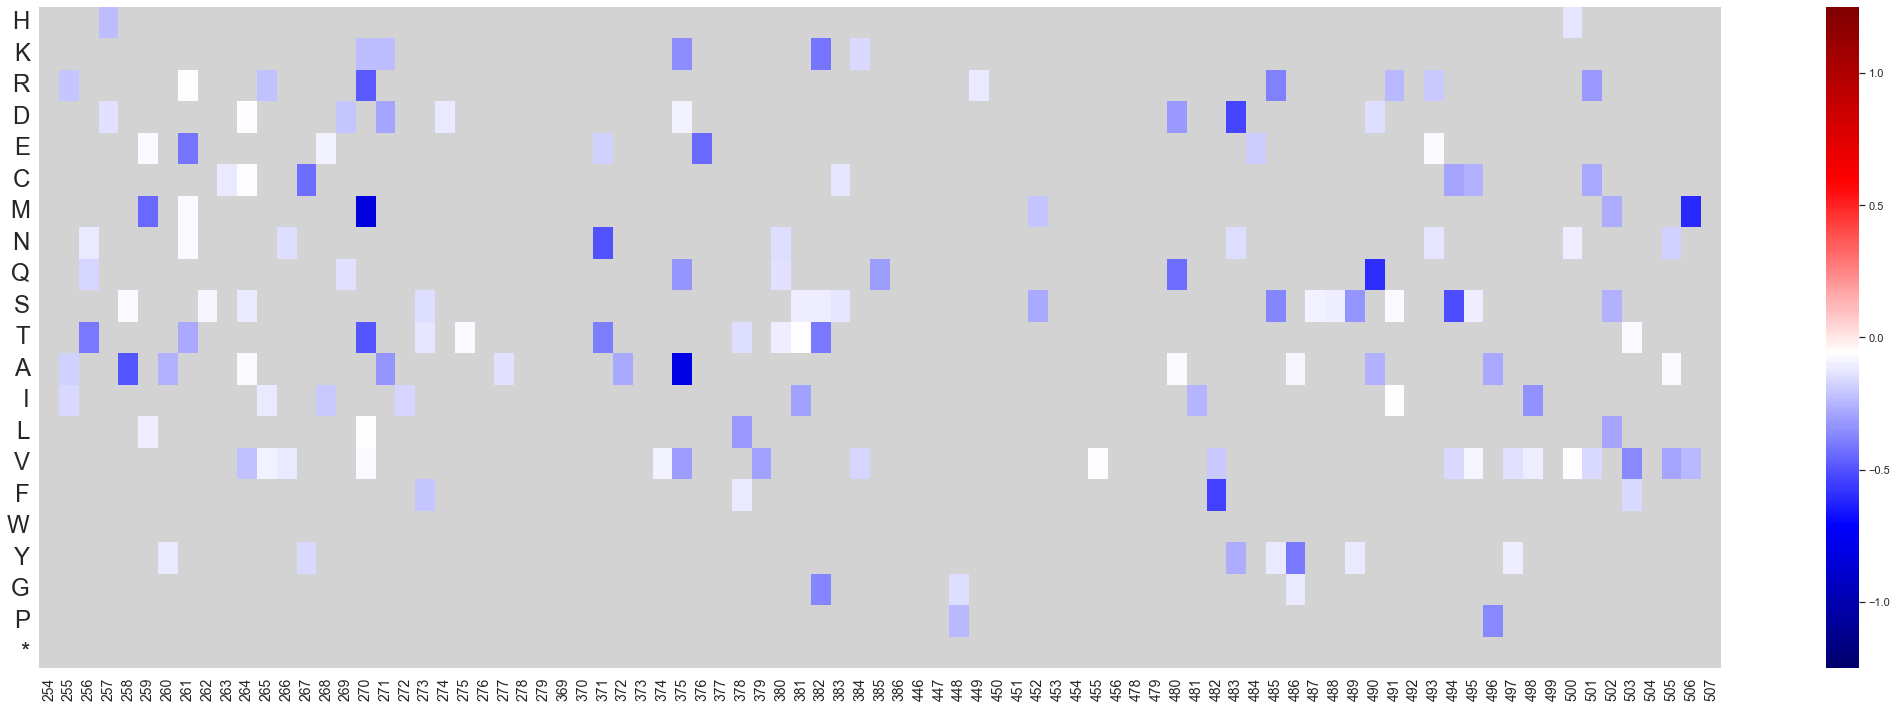

In [23]:
# make plot with just the improved variants
# take only measures with >10 reads at TP-0
df1['tp0_read_mean'] = df1[['1','2','3']].mean(axis=1)
df2 = df1.query('tp0_read_mean >= 10')

df3 = df2.query('k3l_type == "K3L-WT"')[['pkr','log2_fc']]

df3.query('log2_fc < -0.061617', inplace=True)

# + H-K, - D-E, Polar-neutral C-T, Non-polar A-V, Aromatic F-Y, Unique G-P, Stop *
aa_list = ['H','K','R','D','E','C','M','N','Q','S','T','A','I','L','V','F','W','Y','G','P','*']

# create a 3-level dictionary
df3['wt_aa'] = df3.pkr.str.split('-').str[1].str[:1]
df3['var_aa'] = df3.pkr.str.split('-').str[1].str[-1:]
df3['pos'] = df3.pkr.str.split('-').str[1].str[1:-1]
df3['pos'] = pd.to_numeric(df3['pos'])

# remove the PKR-WT variants and residue variant at 420
df3.query('pkr != "PKR-WT"', inplace=True)
df3.query('pkr != "PKR-I420T"', inplace=True)
df3.reset_index(drop=True, inplace=True)

# pivot the df
df3 = df3.pivot(index='pos',columns='var_aa', values='log2_fc')

no_stops_aa = aa_list.copy()
no_stops_aa.remove("*")

for aa in aa_list:
    df3[aa] = df3.get(aa, np.nan)

# average fold change for res position
df3['Mean FC'] = df3[no_stops_aa].mean(axis=1)

# add missing positions to heatmap
good_pos = df3.index.tolist()
#full_pos = list(range(250,551))
full_pos = list(range(254,280))+list(range(369,387))+list(range(446,457))+list(range(478,508))
missing = list(set(full_pos) - set(good_pos))
missing_df = pd.DataFrame(index=missing)
df3 = df3.append(missing_df)
df3.sort_index(inplace=True)
df3.index = df3.index.astype(int)
sns.set_context("talk")

sns.set(rc={'axes.facecolor':'white'})
fig, ax = plt.subplots(figsize=(30,10))
g = sns.heatmap(df3[aa_list].T, cmap='seismic', center=-0.061617, vmin=-1.25, vmax=1.25) # center=0.966365 when no lognorm()

#plt.yticks(rotation=0)
#fig = ax.get_figure()
plt.yticks(rotation=0)

plt.tick_params(axis='y', which='major', labelsize=24)
plt.tick_params(axis='x', which='major', labelsize=14)

#ax.set_xticklabels('')

g.set_facecolor('#D3D3D3'), # gray the background

fig = ax.get_figure()
plt.title('') # Deep mutation scan of PKR variants against K3L-WT log2 FC
plt.ylabel('')
plt.xlabel('')
plt.tight_layout()
fig.savefig('../img/heatmap-pkr_log2-fc_improved-only.pdf')

/tmp/ipykernel_16883/2531736341.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['tp0_read_mean'] = df1[['1','2','3']].mean(axis=1)


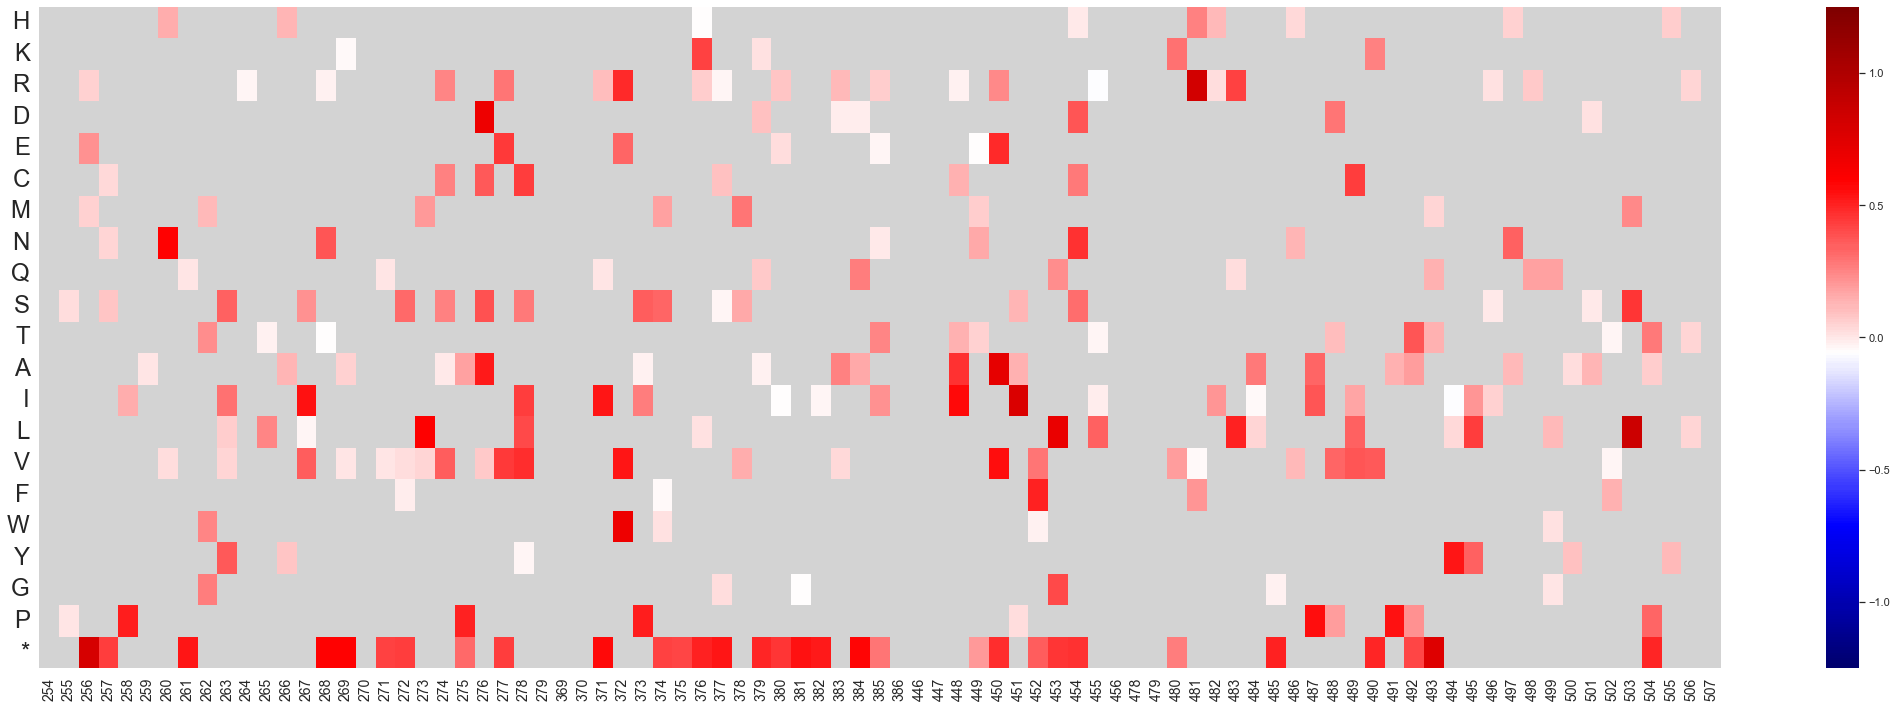

In [22]:
# make plot with just the improved variants
# take only measures with >10 reads at TP-0
df1['tp0_read_mean'] = df1[['1','2','3']].mean(axis=1)
df2 = df1.query('tp0_read_mean >= 10')

df3 = df2.query('k3l_type == "K3L-WT"')[['pkr','log2_fc']]

df3.query('log2_fc > -0.061617', inplace=True)

# + H-K, - D-E, Polar-neutral C-T, Non-polar A-V, Aromatic F-Y, Unique G-P, Stop *
aa_list = ['H','K','R','D','E','C','M','N','Q','S','T','A','I','L','V','F','W','Y','G','P','*']

# create a 3-level dictionary
df3['wt_aa'] = df3.pkr.str.split('-').str[1].str[:1]
df3['var_aa'] = df3.pkr.str.split('-').str[1].str[-1:]
df3['pos'] = df3.pkr.str.split('-').str[1].str[1:-1]
df3['pos'] = pd.to_numeric(df3['pos'])

# remove the PKR-WT variants and residue variant at 420
df3.query('pkr != "PKR-WT"', inplace=True)
df3.query('pkr != "PKR-I420T"', inplace=True)
df3.reset_index(drop=True, inplace=True)

# pivot the df
df3 = df3.pivot(index='pos',columns='var_aa', values='log2_fc')

no_stops_aa = aa_list.copy()
no_stops_aa.remove("*")

for aa in aa_list:
    df3[aa] = df3.get(aa, np.nan)

# average fold change for res position
df3['Mean FC'] = df3[no_stops_aa].mean(axis=1)

# add missing positions to heatmap
good_pos = df3.index.tolist()
#full_pos = list(range(250,551))
full_pos = list(range(254,280))+list(range(369,387))+list(range(446,457))+list(range(478,508))
missing = list(set(full_pos) - set(good_pos))
missing_df = pd.DataFrame(index=missing)
df3 = df3.append(missing_df)
df3.sort_index(inplace=True)
df3.index = df3.index.astype(int)
sns.set_context("talk")

sns.set(rc={'axes.facecolor':'white'})
fig, ax = plt.subplots(figsize=(30,10))
g = sns.heatmap(df3[aa_list].T, cmap='seismic', center=-0.061617, vmin=-1.25, vmax=1.25) # center=0.966365 when no lognorm()

#plt.yticks(rotation=0)
#fig = ax.get_figure()
plt.yticks(rotation=0)

plt.tick_params(axis='y', which='major', labelsize=24)
plt.tick_params(axis='x', which='major', labelsize=14)

#ax.set_xticklabels('')

g.set_facecolor('#D3D3D3'), # gray the background

fig = ax.get_figure()
plt.title('') # Deep mutation scan of PKR variants against K3L-WT log2 FC
plt.ylabel('')
plt.xlabel('')
plt.tight_layout()
fig.savefig('../img/heatmap-pkr_log2-fc_impaired-only.pdf')

In [7]:
# take only measures with >10 reads at TP-0
df1['tp0_read_mean'] = df1[['1','2','3']].mean(axis=1)
df2 = df1.query('tp0_read_mean >= 10')

df3 = df2.query('k3l_type == "K3L-WT"')[['pkr','mean_fold_change']]

# + H-K, - D-E, Polar-neutral C-T, Non-polar A-V, Aromatic F-Y, Unique G-P, Stop *
aa_list = ['H','K','R','D','E','C','M','N','Q','S','T','A','I','L','V','F','W','Y','G','P','*']

# create a 3-level dictionary
df3['wt_aa'] = df3.pkr.str.split('-').str[1].str[:1]
df3['var_aa'] = df3.pkr.str.split('-').str[1].str[-1:]
df3['pos'] = df3.pkr.str.split('-').str[1].str[1:-1]
df3['pos'] = pd.to_numeric(df3['pos'])

# remove the PKR-WT variants and residue variant at 420
df3.query('pkr != "PKR-WT"', inplace=True)
df3.query('pkr != "PKR-I420T"', inplace=True)
df3.reset_index(drop=True, inplace=True)

# pivot the df
df3 = df3.pivot(index='pos',columns='var_aa', values='mean_fold_change')

no_stops_aa = aa_list.copy()
no_stops_aa.remove("*")

# average fold change for res position
df3['Mean FC'] = df3[no_stops_aa].mean(axis=1)

# add missing positions to heatmap
good_pos = df3.index.tolist()
#full_pos = list(range(250,551))
full_pos = list(range(254,280))+list(range(369,387))+list(range(446,457))+list(range(478,508))
missing = list(set(full_pos) - set(good_pos))
missing_df = pd.DataFrame(index=missing)
df3 = df3.append(missing_df)
df3.sort_index(inplace=True)
df3.index = df3.index.astype(int)

/tmp/ipykernel_57815/3939537973.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['tp0_read_mean'] = df1[['1','2','3']].mean(axis=1)


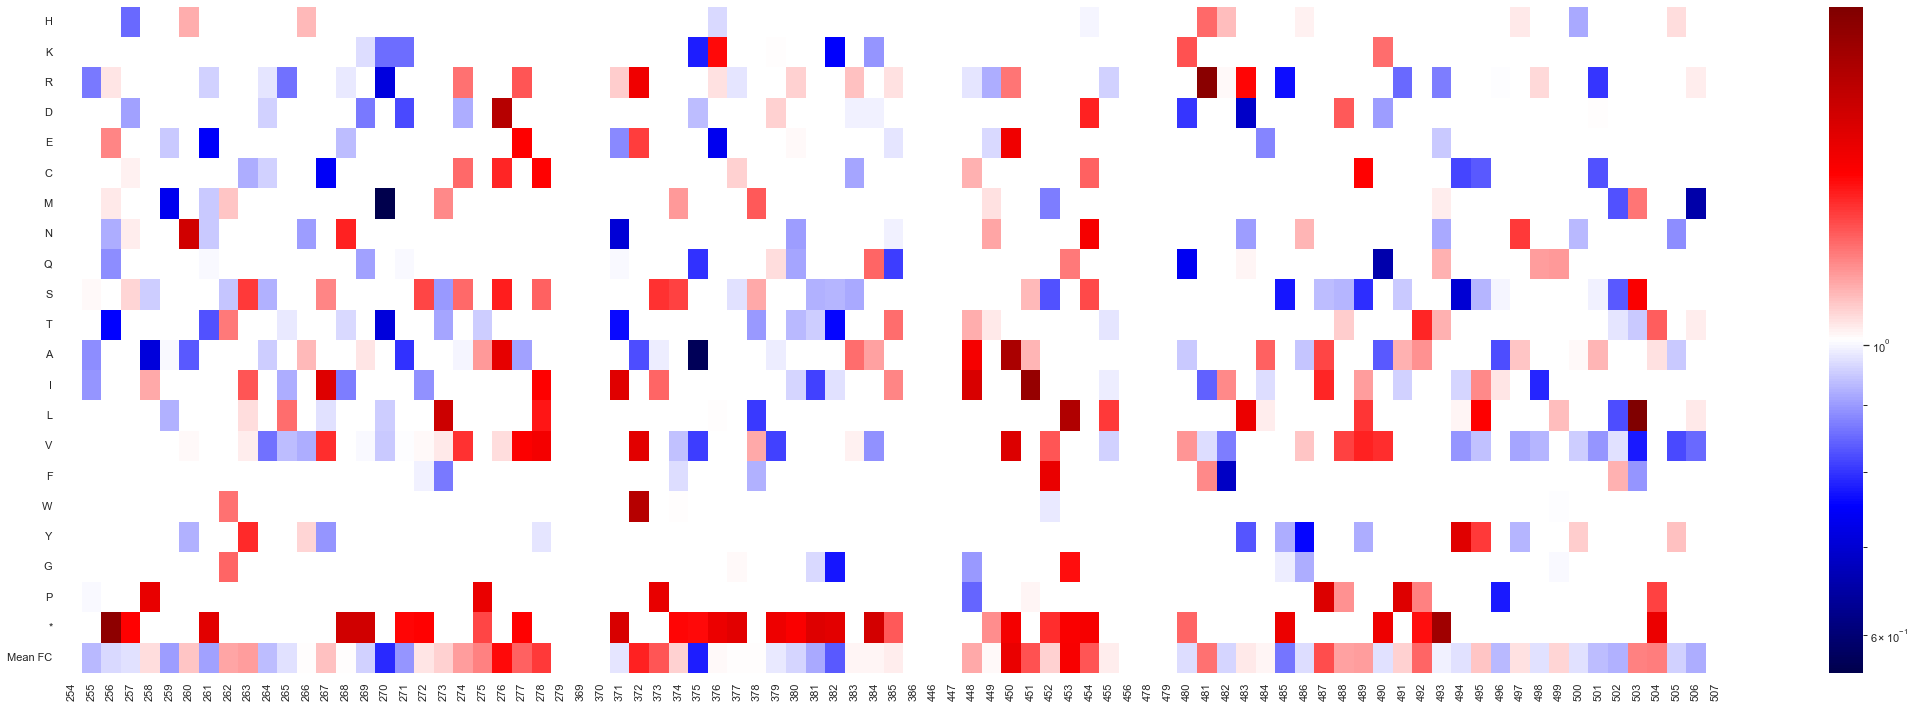

In [8]:
sns.set_context("talk")

sns.set(rc={'axes.facecolor':'white'})
fig, ax = plt.subplots(figsize=(30,10))
g = sns.heatmap(df3[aa_list+['Mean FC']].T, cmap='seismic' , norm=LogNorm()) # center=0.966365 when no lognorm()

plt.yticks(rotation=0)
fig = ax.get_figure()
plt.title('Deep mutation scan of PKR variants against K3L stop-variants')
plt.ylabel('AA variant')
plt.xlabel('PKR residue position')
plt.yticks(rotation=0)

#ax.set_xticklabels('')

fig = ax.get_figure()
plt.title('')
plt.ylabel('')
plt.xlabel('')
plt.tight_layout()
#fig.savefig('../img/heatmap-pkr_lognorm.pdf')

/tmp/ipykernel_57815/1221444182.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['tp0_read_mean'] = df1[['1','2','3']].mean(axis=1)


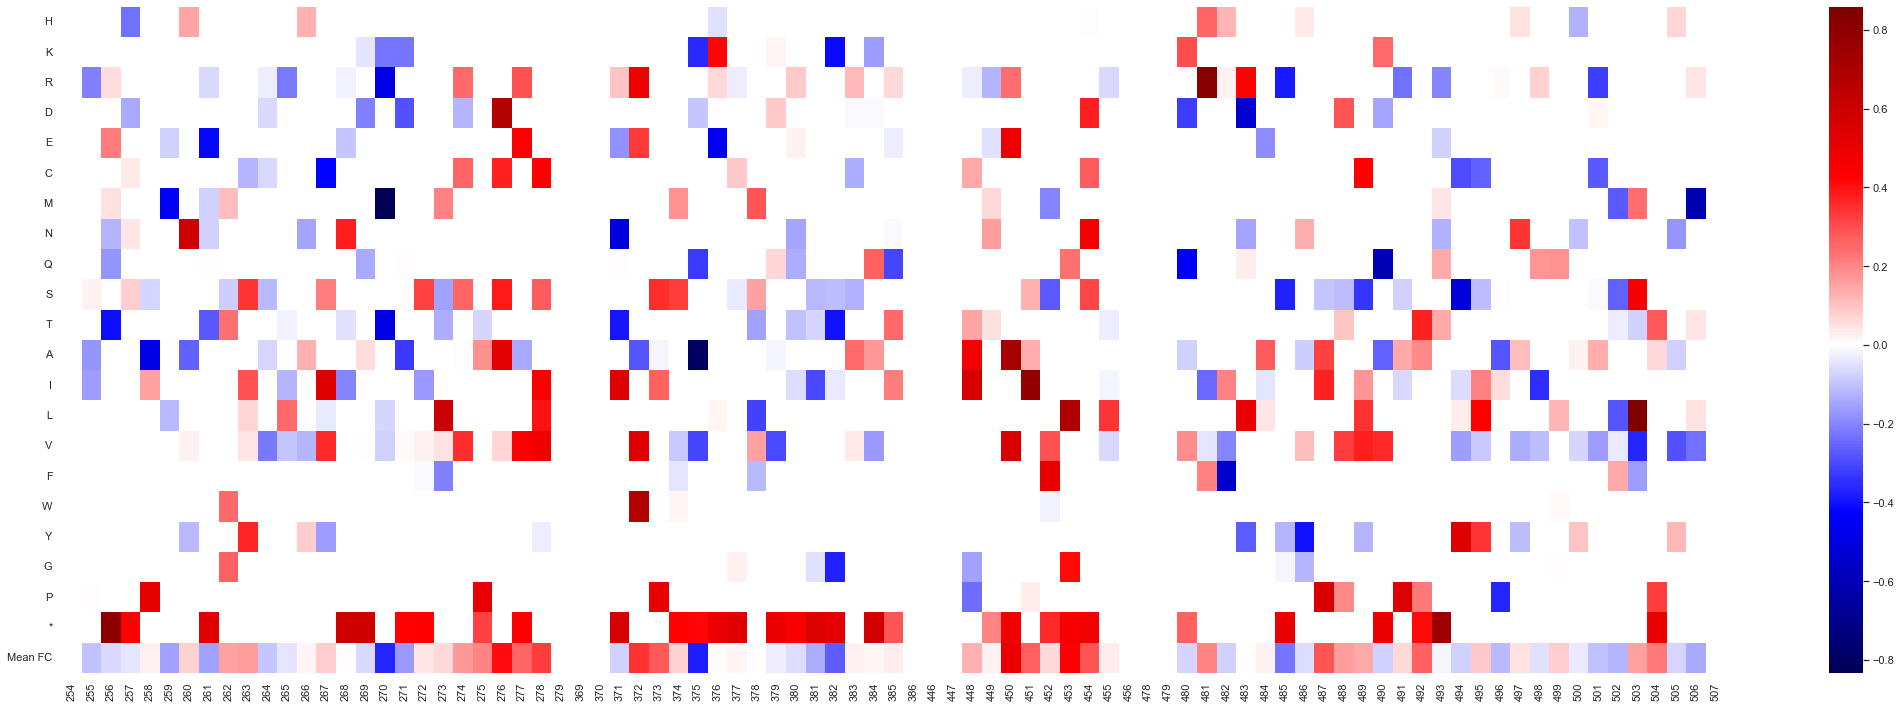

In [13]:
# take only measures with >10 reads at TP-0
df1['tp0_read_mean'] = df1[['1','2','3']].mean(axis=1)
df2 = df1.query('tp0_read_mean >= 10')

df3 = df2.query('k3l_type == "K3L-WT"')[['pkr','log2_fc']]

# + H-K, - D-E, Polar-neutral C-T, Non-polar A-V, Aromatic F-Y, Unique G-P, Stop *
aa_list = ['H','K','R','D','E','C','M','N','Q','S','T','A','I','L','V','F','W','Y','G','P','*']

# create a 3-level dictionary
df3['wt_aa'] = df3.pkr.str.split('-').str[1].str[:1]
df3['var_aa'] = df3.pkr.str.split('-').str[1].str[-1:]
df3['pos'] = df3.pkr.str.split('-').str[1].str[1:-1]
df3['pos'] = pd.to_numeric(df3['pos'])

# remove the PKR-WT variants and residue variant at 420
df3.query('pkr != "PKR-WT"', inplace=True)
df3.query('pkr != "PKR-I420T"', inplace=True)
df3.reset_index(drop=True, inplace=True)

# pivot the df
df3 = df3.pivot(index='pos',columns='var_aa', values='log2_fc')

no_stops_aa = aa_list.copy()
no_stops_aa.remove("*")

# average fold change for res position
df3['Mean FC'] = df3[no_stops_aa].mean(axis=1)

# add missing positions to heatmap
good_pos = df3.index.tolist()
#full_pos = list(range(250,551))
full_pos = list(range(254,280))+list(range(369,387))+list(range(446,457))+list(range(478,508))
missing = list(set(full_pos) - set(good_pos))
missing_df = pd.DataFrame(index=missing)
df3 = df3.append(missing_df)
df3.sort_index(inplace=True)
df3.index = df3.index.astype(int)
sns.set_context("talk")

sns.set(rc={'axes.facecolor':'white'})
fig, ax = plt.subplots(figsize=(30,10))
g = sns.heatmap(df3[aa_list+['Mean FC']].T, cmap='seismic', center=0) # center=0.966365 when no lognorm()

plt.yticks(rotation=0)
fig = ax.get_figure()
plt.title('Deep mutation scan of PKR variants against K3L stop-variants')
plt.ylabel('AA variant')
plt.xlabel('PKR residue position')
plt.yticks(rotation=0)

#ax.set_xticklabels('')

fig = ax.get_figure()
plt.title('')
plt.ylabel('')
plt.xlabel('')
plt.tight_layout()
fig.savefig('../img/heatmap-pkr_log2-fc.pdf')

In [48]:
# df3.pkr.str.split('-').str[1].str[1:-1]
df2[df2.pkr.str.split('-').str[1].str[1:-1] == "420"]

,var,1,2,3,4,5,6,1_norm,2_norm,3_norm,...,6_norm,fold_change_1,fold_change_2,fold_change_3,pkr,k3l,k3l_type,pkr_type,mean_fold_change,tp0_read_mean
1906,PKR-I420T_K3L-WT,11.0,19.0,7.0,8.0,15.0,11.0,0.00004,0.000116,0.000036,...,0.00006,0.974248,0.512284,1.659589,PKR-I420T,K3L-WT,K3L-WT,Variant,1.048707,12.333333


KeyError: "['fold_mean'] not in index"

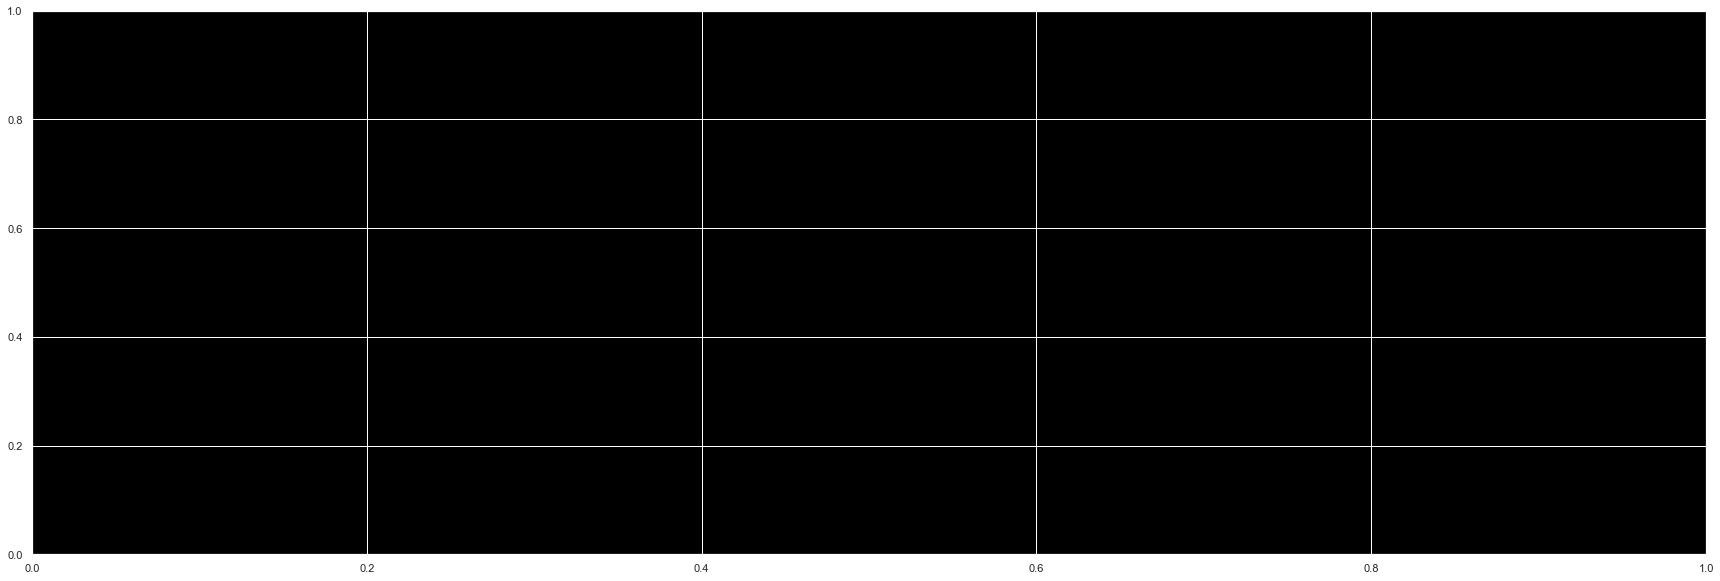

In [39]:
plt.yticks(rotation=0)
fig = ax.get_figure()
plt.title('Deep mutation scan of PKR variants against K3L stop-variants')
plt.ylabel('AA variant')
plt.xlabel('PKR residue position')